In [1]:
# Librerias
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json
import re

In [22]:
nodos = pd.read_csv('../INPUTS/nodos_componente_1.csv', sep=',', index_col="Id")
arcos = pd.read_csv('../INPUTS/arcos_componente_1.csv', sep=',', index_col="Id")


In [3]:
# Funciones
def construir_red(nodos, arcos, dirigida=True):
    if dirigida == True:
        G=nx.DiGraph()
    else:
        G=nx.Graph()
    G.add_nodes_from(nodos.index)
    for nodo in G.nodes:
        for atr in nodos:
            G.nodes[nodo][atr]=nodos[atr][nodo]
    G.add_edges_from([tuple(x) for x in arcos[['SOURCE','TARGET']].to_numpy()])
    return G
G = construir_red(nodos, arcos)

def analizar_top_nodos(analisis_red):
    nodos = []
    for resultado in analisis_red['cálculos para el top 20'].keys():
        for nodo in analisis_red['cálculos para el top 20'][resultado].keys():
            if nodo not in nodos:
                nodos.append(nodo)
            else:
                None

    inventario_nodos = pd.DataFrame(nodos).rename(columns={0:"top_nodos"}).sort_values("top_nodos").reset_index(drop=True)

    for resultado in analisis_red['cálculos para el top 20'].keys():
        inventario_nodos[resultado] = [analisis_red.get("cálculos para el top 20").get(resultado).get(int(ele),np.nan) for ele in inventario_nodos["top_nodos"]]
    return inventario_nodos

def analisis_general_red(graph_networkx, top_nodos=20):
    G = graph_networkx
    G_no_dirigida = G.to_undirected()
    
    analisis_red = {}
    # estadísticas generales de la red
    analisis_red["estadisticas generales"] = {}
    analisis_red["estadisticas generales"]["Es dirigida"] = G.is_directed()
    analisis_red["estadisticas generales"]["Número nodos"] = G.number_of_nodes()
    analisis_red["estadisticas generales"]["Número de aristas"] = G.number_of_edges()
    analisis_red["estadisticas generales"]["Reciprocidad de la red"] = nx.reciprocity(G) # Reciprocidad de la red
    analisis_red["estadisticas generales"]["asortatividad"] = nx.degree_assortativity_coefficient(G) # asortatividad
    analisis_red["estadisticas generales"]["densidad"] = nx.density(G) # Qué proporción de de conexiones entre los nodos existen, esto cambia si es no dirigida

    analisis_red["estadisticas generales"]["fuertemente conectada"] = nx.is_strongly_connected(G) # Puede ser porque sea dirigida o porque hay más de una componente
    analisis_red["estadisticas generales"]["está conectada"] =  G_no_dirigida.is_directed() if G.is_directed() else nx.is_connected(G) # Puede ser porque sea dirigida o porque hay más de una componente
    # Esta medida se ajusta para el análisis de la primera componente
    analisis_red["estadisticas generales"]["diámetro"] = nx.diameter(G) if nx.is_strongly_connected(G) else nx.diameter(G_no_dirigida) # En la primera componente se puede explicar porque hay nodos que solamente reciben (pueden existir otros casos)

    # cálculos sobre la red
    analisis_red["cálculos sobre la red"] = {}
    ## Análisis de las componentes
    
    analisis_red["cálculos sobre la red"]["componentes_de_la_red"] = {i: j for i, j in enumerate(reversed(sorted(list(nx.connected_components(G_no_dirigida)), key=len)))}
    analisis_red["estadisticas generales"]["estadísticas de los componentes"] = {ele:len(analisis_red["cálculos sobre la red"]["componentes_de_la_red"] [ele]) for ele in analisis_red["cálculos sobre la red"]["componentes_de_la_red"].keys()}

    analisis_red["cálculos sobre la red"]["grados"] = G.degree()
    analisis_red["cálculos sobre la red"]["arcos que salen de nodos"] = G.out_degree()
    analisis_red["cálculos sobre la red"]["arcos que llegan a los nodos"] = G.in_degree()
    analisis_red["cálculos sobre la red"]["PageRank"] = nx.pagerank(G)
    analisis_red["cálculos sobre la red"]["centralidad_eigen_vector"] = nx.eigenvector_centrality(G)
    analisis_red["cálculos sobre la red"]["intermediacion"] = nx.betweenness_centrality(G)
    analisis_red["cálculos sobre la red"]["cercania-closeness"] = nx.closeness_centrality(G)
    analisis_red["cálculos sobre la red"]["clustering_dirigido"] = nx.clustering(G) if G.is_directed() else "La red es no dirigida"
    analisis_red["cálculos sobre la red"]["clustering_no_dirigido"] = nx.clustering(G_no_dirigida)


    # resultados para el top
    analisis_red[f"cálculos para el top {top_nodos}"] = {}
    analisis_red[f"cálculos para el top {top_nodos}"]["Nodos más conectados"] = {ele[0]:ele[1] for ele in sorted(dict(G.degree()).items(), key=lambda x: x[1], reverse=True)[:top_nodos]} 
    analisis_red[f"cálculos para el top {top_nodos}"]["nodos con mas arcos que salen"] = {ele[0]:ele[1] for ele in sorted(dict(G.out_degree()).items(), key=lambda x: x[1], reverse=True)[:top_nodos]}
    analisis_red[f"cálculos para el top {top_nodos}"]["nodos con mas arcos que reciben"] = {ele[0]:ele[1] for ele in sorted(dict(G.in_degree()).items(), key=lambda x: x[1], reverse=True)[:top_nodos]}
    analisis_red[f"cálculos para el top {top_nodos}"]["Nodos más PageRank"] = {ele[0]:ele[1] for ele in sorted(nx.pagerank(G).items(), key=lambda x: x[1], reverse=True)[:top_nodos]}
    analisis_red[f"cálculos para el top {top_nodos}"]["nodos_mas_centrales_eigen_vector"] = {ele[0]:ele[1] for ele in sorted(nx.eigenvector_centrality(G).items(), key=lambda x: x[1], reverse=True)[:top_nodos]}
    analisis_red[f"cálculos para el top {top_nodos}"]["nodos_con_mas_intermediacion"] = {ele[0]:ele[1] for ele in sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)[:top_nodos]}
    analisis_red[f"cálculos para el top {top_nodos}"]["nodos_con_mas_cercania"] = {ele[0]:ele[1] for ele in sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)[:top_nodos]}
    analisis_red[f"cálculos para el top {top_nodos}"]["nodos_con_mas_clustering_dirigido"] = {ele[0]:ele[1] for ele in sorted(nx.clustering(G).items(), key=lambda x: x[1], reverse=True)[:top_nodos]} if G.is_directed() else "La red es no dirigida"
    analisis_red[f"cálculos para el top {top_nodos}"]["nodos_con_mas_clustering_no_dirigido"] = {ele[0]:ele[1] for ele in sorted(nx.clustering(G_no_dirigida).items(), key=lambda x: x[1], reverse=True)[:top_nodos]}

    analisis_top = analizar_top_nodos(analisis_red)
    return analisis_red, analisis_top

analisis_red, analisis_top = analisis_general_red(G)

def crear_red_fuertemente_conectada(nxgraph):
    G = nxgraph
    # Encuentra los componentes fuertemente conexos
    sccs = nx.strongly_connected_components(G)
    # Une los componentes fuertemente conexos en un nuevo grafo
    G_scc = nx.compose_all([G.subgraph(c) for c in sccs])
    # Ahora puedes usar G_scc para cálculos que requieren un grafo fuertemente conexo



def exportar_json(diccionario,ruta):
    with open(ruta, "w") as archivo:
        json.dump(diccionario, archivo)

def generar_tabla_componentes (resultado_componentes):
    componentes_red = []
    for componente in resultado_componentes.keys():
        df = pd.DataFrame(resultado_componentes[componente]).rename(columns={0:"nodo"})
        df["componente"] = componente
        componentes_red.append(df)
    
    concatenado = pd.concat(componentes_red).reset_index(drop=True)
    return concatenado



In [4]:
analisis_red

{'estadisticas generales': {'Es dirigida': True,
  'Número nodos': 2074,
  'Número de aristas': 4157,
  'Reciprocidad de la red': 0.0014433485686793362,
  'asortatividad': 0.10909524155762797,
  'densidad': 0.0009668786496354609,
  'fuertemente conectada': False,
  'está conectada': False,
  'diámetro': 17,
  'estadísticas de los componentes': {0: 2074}},
 'cálculos sobre la red': {'componentes_de_la_red': {0: {0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,

In [5]:
exportar_json(analisis_red["estadisticas generales"],"resultados_primera_componente.json")
analisistop_con_metadato = analisis_top.merge(nodos,how="left", left_on="top_nodos",right_on="Id")
analisistop_con_metadato.to_excel("analisistop_con_metadato_primera_componente.xlsx",index=False)


In [34]:
import community
R = nx.to_undirected(G)
louvain = community.best_partition(R,random_state=10)
comLouvain = len(set(louvain.values()))
louvain

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 4,
 8: 7,
 9: 8,
 10: 7,
 11: 9,
 12: 4,
 13: 10,
 14: 4,
 15: 9,
 16: 0,
 17: 7,
 18: 11,
 19: 7,
 20: 10,
 21: 13,
 22: 6,
 23: 7,
 24: 7,
 25: 8,
 26: 7,
 27: 0,
 28: 14,
 29: 15,
 30: 3,
 31: 16,
 32: 17,
 33: 11,
 34: 1,
 35: 18,
 36: 4,
 37: 3,
 38: 0,
 39: 3,
 40: 3,
 41: 17,
 42: 7,
 43: 3,
 44: 10,
 45: 7,
 46: 0,
 47: 2,
 48: 10,
 49: 17,
 50: 19,
 51: 4,
 52: 7,
 53: 8,
 54: 13,
 55: 5,
 56: 20,
 57: 21,
 58: 3,
 59: 7,
 60: 8,
 61: 3,
 62: 1,
 63: 7,
 64: 13,
 65: 1,
 66: 3,
 67: 4,
 68: 10,
 69: 3,
 70: 21,
 71: 15,
 72: 7,
 73: 14,
 74: 20,
 75: 22,
 76: 11,
 77: 3,
 78: 4,
 79: 5,
 80: 4,
 81: 9,
 82: 0,
 83: 14,
 84: 1,
 85: 4,
 86: 0,
 87: 3,
 88: 0,
 89: 21,
 90: 10,
 91: 3,
 92: 3,
 93: 9,
 94: 0,
 95: 2,
 96: 6,
 97: 13,
 98: 15,
 99: 4,
 100: 23,
 101: 1,
 102: 7,
 103: 8,
 104: 20,
 105: 10,
 106: 1,
 107: 9,
 109: 7,
 110: 0,
 111: 21,
 112: 7,
 113: 14,
 114: 11,
 115: 23,
 116: 2,
 117: 13,
 118: 0,
 119: 20,

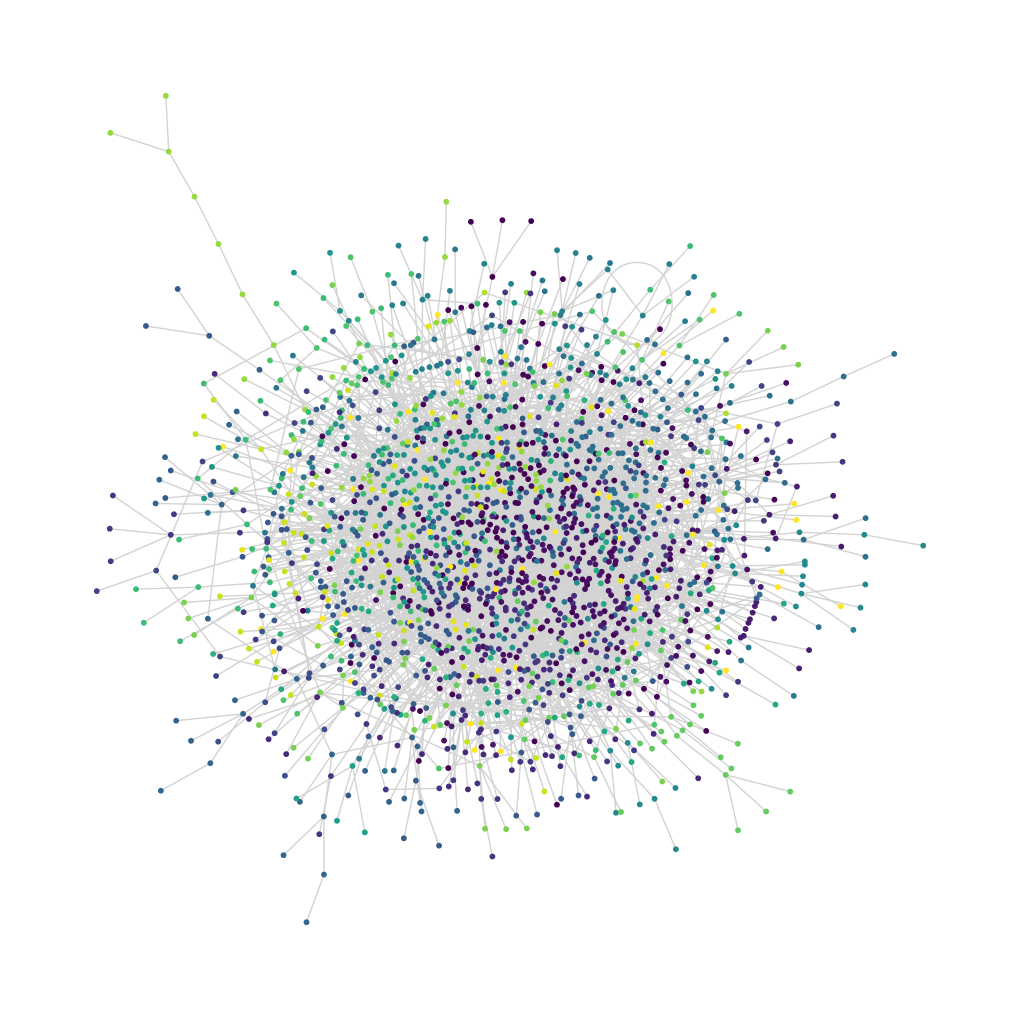

In [9]:
# Definir lienzo
fig=plt.figure(figsize=(10,10))

# Guardar posiciones
pos = nx.kamada_kawai_layout(R)

# Graficar
nx.draw(R, pos=pos, node_size=10, node_color=list(louvain.values()),edge_color='lightgray')

# Mostrar gráfica                
plt.show()

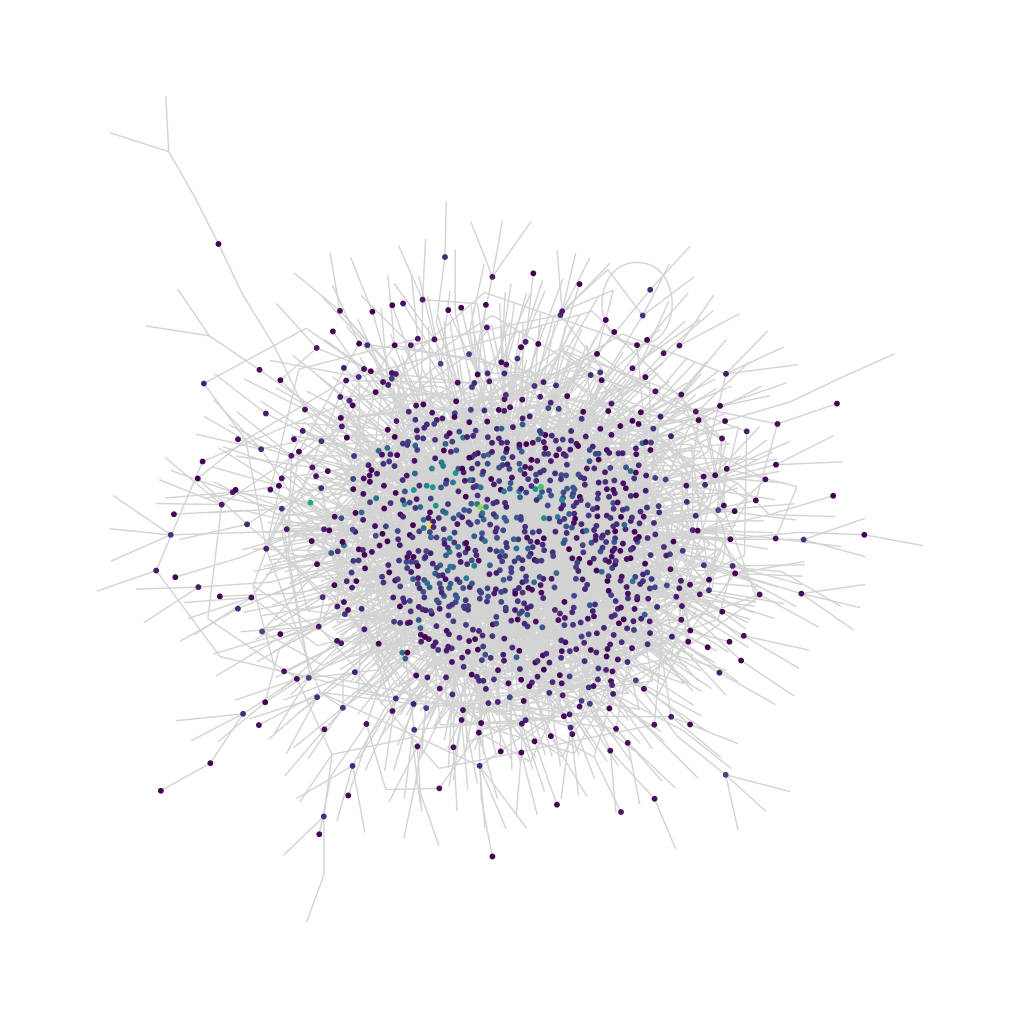

In [32]:
# Definir lienzo
fig=plt.figure(figsize=(10,10))

# Guardar posiciones
pos = nx.kamada_kawai_layout(R)

# Graficar
nx.draw(R, pos=pos, node_size=10, node_color=list(nodos['Number of Lead Investors']),edge_color='lightgray')

# Mostrar gráfica                
plt.show()




In [25]:
dict_copmany_type = nodos['Company Type'].value_counts(dropna=False)
dict_copmany_type = dict_copmany_type.to_dict()
dict_copmany_type.keys()
# G.nodes[node]["Estado_t"]=G.nodes[node]["Estado_t1"]

dict_keys(['For Profit', nan, 'Non-profit'])

In [37]:

louvain
nodos.reset_index()


,Id,Label,Headquarters Location,Operating Status,Company Type,Number of Investments,Number of Lead Investments,Number of Diversity Investments,Number of Exits,Number of Lead Investors,...,Total Funding Amount Currency,Total Funding Amount Currency (in USD),Number of Events,SEMrush - Monthly Visits,SEMrush - Average Visits (6 months),SEMrush - Visit Duration,Aberdeen - IT Spend,Aberdeen - IT Spend Currency,Aberdeen - IT Spend Currency (in USD),Principales inversionistas
0,0,Capital One,"Mclean, Virginia, United States",Active,For Profit,24.0,10.0,1.0,11.0,NaN,...,NaN,NaN,93.0,"138,620,910","142,691,008.83",419.000,3.209361e+09,USD,3.209361e+09,NaN
1,1,Hivemapper,"San Francisco, California, United States",Active,For Profit,NaN,NaN,NaN,NaN,2.0,...,USD,21000000.0,NaN,17.141,15.542,168.000,NaN,NaN,NaN,"Spark Capital, GV, 75 & Sunny, Craft Ventures,..."
2,2,Innova Memphis,"Memphis, Tennessee, United States",Active,NaN,305.0,61.0,104.0,9.0,NaN,...,NaN,NaN,NaN,5.022,NaN,7.000,NaN,NaN,NaN,NaN
3,3,NewView Capital,"Burlingame, California, United States",Active,For Profit,44.0,9.0,5.0,4.0,NaN,...,NaN,NaN,NaN,5.948,NaN,0.000,NaN,NaN,NaN,NaN
4,4,US Angel Investors,"Palo Alto, California, United States",Active,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.132,NaN,33.000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2069,2114,Nazara Technologies,"Mumbai, Maharashtra, India",Active,For Profit,11.0,10.0,NaN,3.0,6.0,...,USD,146371285.0,NaN,11.634,"17,922.33",98.000,NaN,NaN,NaN,"Sequoia Capital, Westbridge Capital, IIFL Asse..."
2070,2115,BigBear.ai,"Columbia, Maryland, United States",Active,For Profit,NaN,NaN,NaN,NaN,NaN,...,USD,200000000.0,NaN,33.789,"15,032.83",458.000,NaN,NaN,NaN,"Fortress Investment Group, Marathon Asset Mana..."
2071,2116,Arca,"Los Angeles, California, United States",Active,For Profit,10.0,1.0,NaN,1.0,2.0,...,USD,10000000.0,NaN,33.578,"22,816.5",71.000,NaN,NaN,NaN,"RRE Ventures, Arca, Littlebanc Advisors LLC., ..."
2072,2117,Matrixport,"Singapore, Central Region, Singapore",Active,For Profit,5.0,NaN,NaN,NaN,3.0,...,USD,100000000.0,NaN,443.096,"367,762.83",1.532,NaN,NaN,NaN,"IDG Capital, Tiger Global Management, Polychai..."
